In [1]:
library(tidyverse)
library(ggplot2)
library(patchwork)
source("helper.R")
library(pdftools)
library(scales)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.1.2     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor




In [2]:
sinfo_path = "../../output/sims_info.tsv"
sinfoh_path = "../../output/header_sims_info.tsv"

In [3]:
win_size = 1000000
chroms= c("chr12")
win_len = -1
padding = 0
rescf = 1
prop_acc=0.4

In [4]:
fig_prefixes = c("cor-pidxy-dT", "subset-chr12-landscapes","annot-correls-tmrca")
widths = c(100, 125, 100)
heights = c(25, 25, 35)
#fig_prefixes = c("annot-correls-tmrca")

In [5]:
sims_path = "../../output/sims_results/"
varmut_sims_path = "../../output/varmut/sims_results/"
pref = "cor-pidxy-pidxy"
data_path=paste0("../../output/greatapes-diversity-data/chr12/cor-pidxy-pidxy_win-size_",as.integer(win_size),"_merged-mask_True_state_all_curr_all_prop-acc_0.4.tsv")

In [6]:
# loading sims info table
sinfo = read.table(sinfo_path, sep="\t")
h = read.table(sinfoh_path, sep="\t", header=TRUE)
cnames = colnames(h)
if (length(sinfo) == length(h)+1) {
    cnames = c(cnames, "poscoefdecayeps")
}
colnames(sinfo) = cnames

In [7]:
#diff_cols = c("delrate","delcoef","posrate","poscoef","mu", "rescf", "win_len", "padding", "chr")
diff_cols = c("delrate","delcoef","posrate","poscoef","mu", "poscoefdecayeps", "rescf", "win_len", "padding", "chr")

In [8]:
wsize_str = paste0("win-size_",as.integer(win_size))

In [9]:
sims_folders = paste0(sims_path,list.files(sims_path)[grep(wsize_str, list.files(sims_path))])

In [10]:
varmut_sims_folders = paste0(varmut_sims_path,list.files(varmut_sims_path)[grep(wsize_str, list.files(varmut_sims_path))])

In [11]:
sims_folders = c(sims_folders, varmut_sims_folders)

In [12]:
simresults = as.data.frame(do.call(rbind, lapply(X = sims_folders, function(x) unlist(meta_from_fname(x,prop=prop_acc,suffix="$")))), stringsAsFactors =FALSE)

[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"
[1] "entrei"


In [13]:
simresults$folderpath = sims_folders

In [14]:
tmp = unique(sinfo[sinfo$sup_rand_id %in% simresults$sup_rand_id,c(diff_cols,"sup_rand_id")])

In [15]:
simresults = left_join(simresults, tmp)
simresults$posrate[is.na(simresults$posrate)] = 0

Joining, by = "sup_rand_id"



In [16]:
simresults = simresults[simresults$win_len==win_len &
                        simresults$padding == padding &
                        simresults$rescf==1 &
                        as.numeric(simresults$win_size) == win_size &
                        simresults$chr %in% chroms &
                        simresults$posrate <= 1.8e-11,]

In [17]:
simresults[is.na(simresults$poscoefdecayeps),]$poscoefdecayeps = 0

In [18]:
simresults$selregime = ifelse(simresults$posrate<1e-16,ifelse(simresults$delrate<1e-16, ifelse(simresults$sigma==0, "neutral", "varmut"), "del_only"), ifelse(simresults$delrate<1e-16, "pos_only", "both"))

In [19]:
simresults$seldesc = apply(
    simresults,
    1,
    function(x) paste("mu-D=", x["delrate"],
                      " mu-B=", x["posrate"],
                      ifelse(x['selregime'] %in% c("del_only", "both"), paste0("\ncoef-D=", x["delcoef"]), ""),
                      ifelse(x['selregime'] %in% c("both", "pos_only"), paste0("\ncoef-B=", x["poscoef"], " decay-B=", x["poscoefdecayeps"]), ""),
                      ifelse(x["selregime"]=="varmut", paste0(" mut-sd=", x['sigma']),""),
                      "\n(", x["sup_rand_id"], ")", 
                      sep=""))
simresults$seldesc_norandid = apply(
    simresults,
    1,
    function(x) paste("mu-D=", x["delrate"],
                      " mu-B=", x["posrate"],
                      ifelse(x['selregime'] %in% c("del_only", "both"), paste0("\ncoef-D=", x["delcoef"]), ""),
                      ifelse(x['selregime'] %in% c("both", "pos_only"), paste0("\ncoef-B=", x["poscoef"], " decay-B=", x["poscoefdecayeps"]), ""),
                      ifelse(x["selregime"]=="varmut", paste0(" mut-sd=", x['sigma']),""), 
                      sep=""))

In [20]:
simresults$seldesc_norandid = str_replace_all(simresults$seldesc_norandid, "\n", " ")
simresults$seldesc_norandid = str_replace(simresults$seldesc_norandid, " \\(.+$", "")
simresults$seldesc_norandid = str_replace(simresults$seldesc_norandid, " coef-.+$", "")
simresults$seldesc_norandid = str_replace_all(simresults$seldesc_norandid, "mu-D=0.0e\\+00", "")
simresults$seldesc_norandid = str_replace_all(simresults$seldesc_norandid, "mu-B=0e\\+00", "")
simresults$seldesc_norandid = str_replace_all(simresults$seldesc_norandid, "data", "Data")
simresults$seldesc_norandid = str_replace_all(simresults$seldesc_norandid, "mu", "\\u03bc")
simresults$seldesc_norandid = str_replace_all(simresults$seldesc_norandid, "-D", "\\u2099")
simresults$seldesc_norandid = str_replace_all(simresults$seldesc_norandid, "-B", "\\u209a")
simresults$seldesc_norandid = str_replace(simresults$seldesc_norandid, "\\u03bct", "\\u03bc")

In [21]:
simresults$sigma = as.numeric(simresults$sigma)

In [22]:
tmp = simresults
ordered = c("neutral", "del_only", "pos_only", "both", "varmut")
classes = unique(tmp$selregime)
tmp$selregime = factor(tmp$selregime, levels=classes[order(match(classes,ordered))])
tmp = tmp[
  with(tmp, order(selregime,posrate,-poscoefdecayeps,delrate,poscoef,delcoef,sigma)),
]
simresults=tmp

In [23]:
simresults[simresults$sup_rand_id == "4GROMS6FHMNW5X9L72",]

,win_size,sup_rand_id,rep,sample_size,spaced_desc,desc,prop,is_ga_data,sigma,state,⋯,poscoef,mu,poscoefdecayeps,rescf,win_len,padding,chr,selregime,seldesc,seldesc_norandid
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<fct>,<chr>,<chr>
45,1000000,4GROMS6FHMNW5X9L72,0,10,sup-rand-id=4GROMS6FHMNW5X9L72 rep=0 win-size=1000000 sample-size=10 prop-acc=0.4,sup-rand-id_4GROMS6FHMNW5X9L72_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4,0.4,FALSE,0,all,⋯,0.01,1e-11,0,1,-1,0,chr12,pos_only,mu-D=0.0e+00 mu-B=1e-11 coef-B=0.010 decay-B=0.000 (4GROMS6FHMNW5X9L72),<U+03BC><U+209A>=1e-11


In [24]:
data_row = simresults[1,]
data_row$sup_rand_id="data"
data_row$spaced_desc="data"
data_row$desc="data"
data_row$is_ga_data=TRUE
data_row$sigma=0
data_row$state="all"
data_row$folderpath = data_path
data_row$delrate=0
data_row$delcoef=0
data_row$posrate=0
data_row$poscoef=0
data_row$mu=0
data_row$poscoefdecayeps=0
data_row$rescf=0
data_row$win_len=0
data_row$padding=0
data_row$selregime="data"
data_row$seldesc="data"
data_row$chr = "chr12"

In [25]:

a = apply(simresults,1, function(x) read.table(paste0(x["folderpath"],
                                             "/",pref, "_",x["desc"],".tsv"), sep="\t", header=TRUE))

In [26]:
data_df = read.table(data_row$folderpath,sep="\t",header=TRUE)
#data_df = data_df[data_df$chr %in% chroms,] # getting only chroms of interest

In [27]:

simresults = rbind(simresults,data_row)

In [28]:
a = append(a,list(data_df))

In [29]:
length(a)

[1] 38

In [30]:
names(a) = simresults$desc

In [31]:
a = bind_rows(a, .id="id")

In [32]:
a = left_join(a, simresults, by=c("id"="desc"))

In [33]:
a[,c("spp1_1", "spp2_1")] = t(apply(a[,c("spp1_1", "spp2_1")], 1, sort))
a[,c("spp1_2", "spp2_2")] = t(apply(a[,c("spp1_2", "spp2_2")], 1, sort))

a$spp1 = paste(a$spp1_1, a$spp2_1, sep="_")
a$spp2 = paste(a$spp1_2, a$spp2_2, sep="_")
a[,c("spp1", "spp2")] = t(apply(a[,c("spp1", "spp2")], 1, sort))

Warning message:
"Removed 1722 rows containing non-finite values (stat_smooth)."


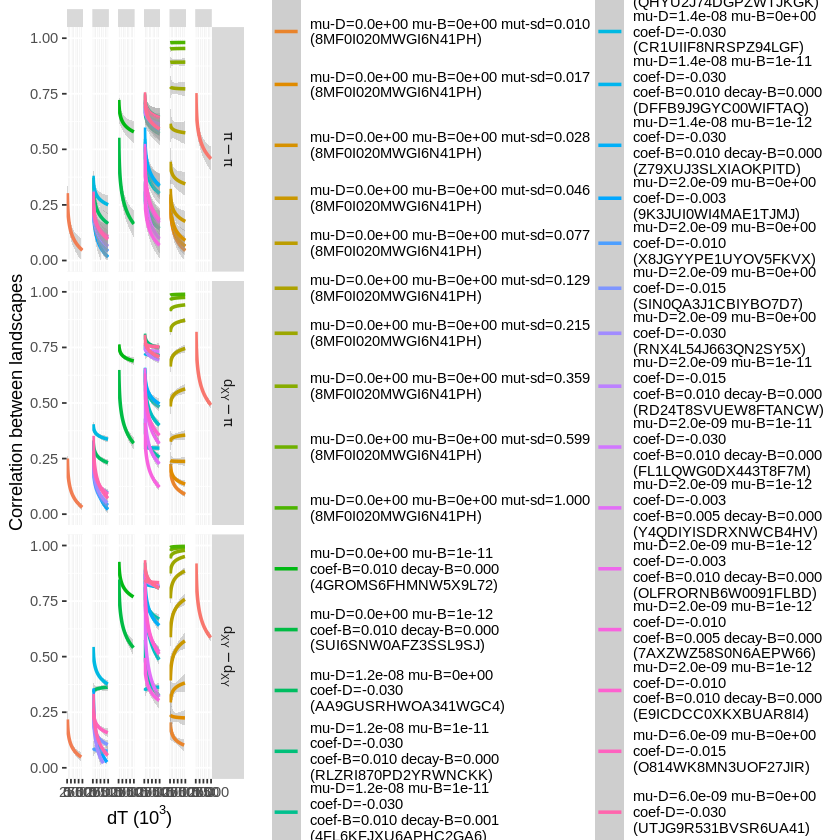

In [34]:
statcombolabs = c(`dxy_dxy`="d[XY]-d[XY]", `dxy_pi`="d[XY]-pi", `pi_pi`="pi-pi")
lownelabs = c(`TRUE`="Yes", `False`="No")
p_dt = ggplot(a[a$has_shared == FALSE,], aes(y=value, x=dt, col=seldesc)) +
    geom_smooth(formula = y ~ I(log(x)), method="lm") +
    scale_shape_manual(values=c(19, 18), labels=c("No", "Yes")) +
    scale_x_continuous(labels = label_number(scale = 1e-3)) +
    #scale_color_viridis_d(direction=-1, end=0.7) +
    facet_grid(factor(statcombo, levels=c("pi_pi", "dxy_pi", "dxy_dxy"))~selregime, scales="free", labeller=as_labeller(statcombolabs, default=label_parsed)) +
    labs(x=bquote("dT ("*10^3*")"), y="Correlation between landscapes", shape=bquote(pi*" in low "*N[e]*" species?"), col="Number of species involved\nin the comparison") +
    ylim(0,1) +
    guides(colour = guide_legend(title.position="top"), shape = guide_legend(title.position="top"))

p_dt

In [35]:
head(a)

,id,stat_combo1,stat_combo2,value,mrca1,stat1,spp1_1,spp2_1,mrca2,stat2,⋯,poscoefdecayeps,rescf,win_len,padding,chr,selregime,seldesc,seldesc_norandid,spp1,spp2
,<chr>,<fct>,<fct>,<dbl>,<fct>,<fct>,<chr>,<chr>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>
1,sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4,dxy_bornean-orangutan sumatran-orangutan,pi_bornean-orangutan,0.353769573,orangutans,dxy,bornean-orangutan,sumatran-orangutan,bornean-orangutan,pi,⋯,0,1,-1,0,chr12,neutral,mu-D=0.0e+00 mu-B=0e+00 (8MF0I020MWGI6N41PH),,bornean-orangutan_bornean-orangutan,bornean-orangutan_sumatran-orangutan
2,sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4,pi_sumatran-orangutan,pi_bornean-orangutan,0.131607645,sumatran-orangutan,pi,sumatran-orangutan,sumatran-orangutan,bornean-orangutan,pi,⋯,0,1,-1,0,chr12,neutral,mu-D=0.0e+00 mu-B=0e+00 (8MF0I020MWGI6N41PH),,bornean-orangutan_bornean-orangutan,sumatran-orangutan_sumatran-orangutan
3,sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4,dxy_bornean-orangutan eastern-gorilla,pi_bornean-orangutan,-0.002749761,great-apes,dxy,bornean-orangutan,eastern-gorilla,bornean-orangutan,pi,⋯,0,1,-1,0,chr12,neutral,mu-D=0.0e+00 mu-B=0e+00 (8MF0I020MWGI6N41PH),,bornean-orangutan_bornean-orangutan,bornean-orangutan_eastern-gorilla
4,sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4,dxy_eastern-gorilla sumatran-orangutan,pi_bornean-orangutan,-0.031864881,great-apes,dxy,eastern-gorilla,sumatran-orangutan,bornean-orangutan,pi,⋯,0,1,-1,0,chr12,neutral,mu-D=0.0e+00 mu-B=0e+00 (8MF0I020MWGI6N41PH),,bornean-orangutan_bornean-orangutan,eastern-gorilla_sumatran-orangutan
5,sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4,pi_eastern-gorilla,pi_bornean-orangutan,0.088242814,eastern-gorilla,pi,eastern-gorilla,eastern-gorilla,bornean-orangutan,pi,⋯,0,1,-1,0,chr12,neutral,mu-D=0.0e+00 mu-B=0e+00 (8MF0I020MWGI6N41PH),,bornean-orangutan_bornean-orangutan,eastern-gorilla_eastern-gorilla
6,sup-rand-id_8MF0I020MWGI6N41PH_rep_0_win-size_1000000_sample-size_10_prop-acc_0.4,dxy_bornean-orangutan western-gorilla,pi_bornean-orangutan,-0.005635184,great-apes,dxy,bornean-orangutan,western-gorilla,bornean-orangutan,pi,⋯,0,1,-1,0,chr12,neutral,mu-D=0.0e+00 mu-B=0e+00 (8MF0I020MWGI6N41PH),,bornean-orangutan_bornean-orangutan,bornean-orangutan_western-gorilla


In [36]:
wide_a = a[,c("id","spp1", "spp2", "selregime", "seldesc", "seldesc_norandid", "value")] %>%
    pivot_wider(id_cols=c("id","selregime","seldesc", "seldesc_norandid"),
                names_from=c("spp1", "spp2"),
                values_from=c("value"),
                names_sep="__") %>%
    ungroup()

In [37]:
corrs_pca <- prcomp(select(wide_a,-c("id","selregime","seldesc", "seldesc_norandid")), center = TRUE,scale. = TRUE)


In [38]:
components <- corrs_pca[["x"]]
components <- data.frame(components)
components <- cbind(components, wide_a$selregime)
components <- cbind(components, wide_a$seldesc)
props = round(summary(corrs_pca)[[6]][2,]*100,2)

In [39]:
library(ggfortify)

In [40]:
wide_a$selregime = factor(wide_a$selregime, levels=c("data", "neutral", "del_only", "pos_only", "both", "varmut"), labels=c("Empirical data", "Neutral", "BGS", "Sweeps", "Both", "MRV"))


In [41]:
pcadf <- data.frame(selregime = wide_a$selregime,
                                       PC1 = corrs_pca$x[,1],
                                       PC2 = corrs_pca$x[,2])

In [42]:
selected_points = c("mu-D=0.0e+00 mu-B=0e+00\n(8MF0I020MWGI6N41PH)",
                    "data",
                    "mu-D=1.2e-08 mu-B=1e-12\ncoef-D=-0.030\ncoef-B=0.010 decay-B=0.000\n(HVD283AEPBL88J4NUN)", 
                    "mu-D=1.4e-08 mu-B=1e-12\ncoef-D=-0.030\ncoef-B=0.010 decay-B=0.000\n(Z79XUJ3SLXIAOKPITD)", 
                    "mu-D=0.0e+00 mu-B=1e-11\ncoef-B=0.010 decay-B=0.000\n(4GROMS6FHMNW5X9L72)", 
                    "mu-D=0.0e+00 mu-B=1e-12\ncoef-B=0.010 decay-B=0.000\n(SUI6SNW0AFZ3SSL9SJ)", 
                    "mu-D=0.0e+00 mu-B=0e+00 mut-sd=0.077\n(8MF0I020MWGI6N41PH)")

In [43]:
pcadf$seldesc_norandid = wide_a$seldesc_norandid
pcadf$seldesc = wide_a$seldesc

In [44]:
pcadf[!pcadf$seldesc %in% selected_points,]$seldesc_norandid = ""


In [45]:
pcadf[pcadf$seldesc_norandid == " ",]$seldesc_norandid = as.character(pcadf[pcadf$seldesc_norandid == " ",]$selregime)

In [46]:
library(ggrepel)

In [47]:
cols6 = c("#b3943f",
"#9565c8",
"#62a85b",
"#c85b8e",
"#6295cd",
"#cc5c42")
pcap = ggplot(pcadf, aes(x=PC1,y=PC2, col=selregime, label=seldesc_norandid)) + 
    geom_point(size=2) + 
    scale_colour_manual(values=cols6) + 
    labs(col="Regime", x=paste0("PC1 ","(",props["PC1"],"%)"), y=paste0("PC2 ","(",props["PC2"],"%)")) + 
    theme_bw(base_size=18) + 
    geom_text_repel(min.segment.length = 0, show.legend = FALSE) +
    theme(legend.position="top")

ggsave("../../output/final_figs/pca.pdf", width=6, height=6, device=cairo_pdf)

In [48]:
pcadf$seldesc_norandid

[1] "Neutral"                                
 [2] ""                                       
 [3] ""                                       
 [4] ""                                       
 [5] ""                                       
 [6] ""                                       
 [7] ""                                       
 [8] ""                                       
 [9] ""                                       
[10] " <U+03BC><U+209A>=1e-12"                
[11] " <U+03BC><U+209A>=1e-11"                
[12] ""                                       
[13] ""                                       
[14] ""                                       
[15] ""                                       
[16] ""                                       
[17] ""                                       
[18] "<U+03BC><U+2099>=1.2e-08 <U+03BC><U+209A>=1e-12"
[19] "<U+03BC><U+2099>=1.4e-08 <U+03BC><U+209A>=1e-12"
[20] ""                                       
[21] ""                                       
[22] ""                                       
[23] ""                                       
[24] ""                                       
[25] ""                                       
[26] ""                                       
[27] ""                                       
[28] ""                                       
[29] ""                                       
[30] ""                                       
[31] ""                                       
[32] "  <U+03BC>-sd=0.077"                    
[33] ""                                       
[34] ""                                       
[35] ""                                       
[36] ""                                       
[37] ""                                       
[38] "Empirical data"

In [ ]:
barplot(sort(corrs_pca$rotation[,1]^2, decreasing=TRUE))

In [ ]:
barplot(sort(corrs_pca$rotation[,2]^2, decreasing=TRUE))

In [ ]:
nrow(corrs_pca$rotation)

In [ ]:
tail(sort(corrs_pca$rotation[,2]^2), 14)

In [ ]:
tail(sort(corrs_pca$rotation[,1]^2), 14)

In [ ]:
head(sort(corrs_pca$rotation[,1]^2), 14)